In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
PLOTS_FOLDER = "../plots"

In [3]:
def prep_data(thresh):
    df = pd.read_csv(f"../data/tatoeba_tf_train_thresh{thresh}.tsv", sep="\t", index_col=0)
    unique_cnts = df.nunique(axis=0)
    const_feats = unique_cnts[unique_cnts == 1]
    df.drop(const_feats.index.tolist(), axis=1, inplace=True)
    return df

In [6]:
score_df = pd.read_csv(f"../data/tatoeba_train_opus_scores.tsv", sep="\t", index_col=0)

y = score_df.bleu

del score_df

In [9]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Ridge
from sklearn.preprocessing import StandardScaler

In [15]:
from sklearn.metrics import r2_score, mean_squared_error

In [12]:
RANDOM_SEED = 0

In [42]:
def get_metrics(alphas, X, y):
    X_train, X_test = X
    y_train, y_test = y

    r2s = []
    mses = []

    for alpha in np.logspace(-3, 3, num=30):
        model = Ridge(alpha=alpha).fit(X_train, y_train)
        y_pred = model.predict(X_test)
        r2s.append(r2_score(y_test, y_pred))
        mses.append(mean_squared_error(y_test, y_pred))

    return np.array(r2s), np.array(mses)

In [43]:
def plot_metrics(thresh, alphas, r2s, mses):
    plt.figure(figsize=(8, 12))

    plt.subplot(211)

    sns.lineplot(x=alphas, y=r2s)

    ax = plt.gca()
    ax.set_xscale("log")
    ax.set(xlabel="Regularization coefficient", ylabel="$ R^2 $")

    ax.grid()

    plt.subplot(212)

    sns.lineplot(x=alphas, y=mses)

    ax = plt.gca()
    ax.set_xscale("log")
    ax.set(xlabel="Regularization coefficient", ylabel="MSE")

    ax.grid()

    plt.suptitle(f"Metrics for linear regression\nTopological features, threshold {thresh}")

    plt.show()

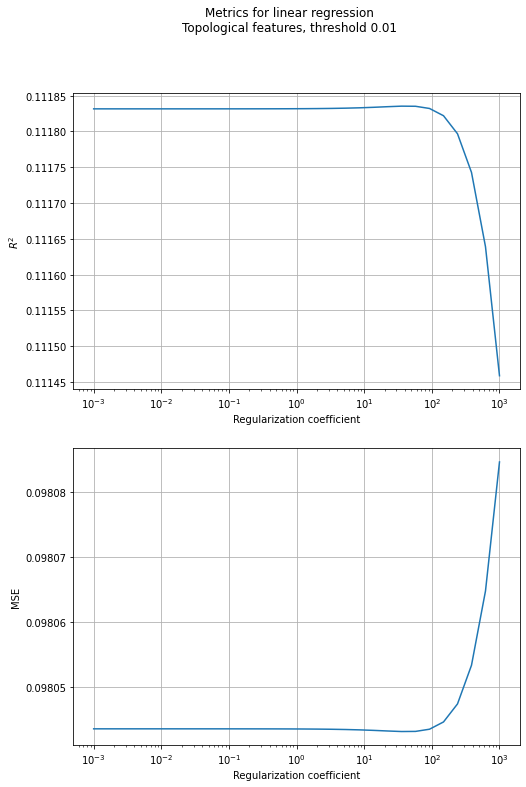

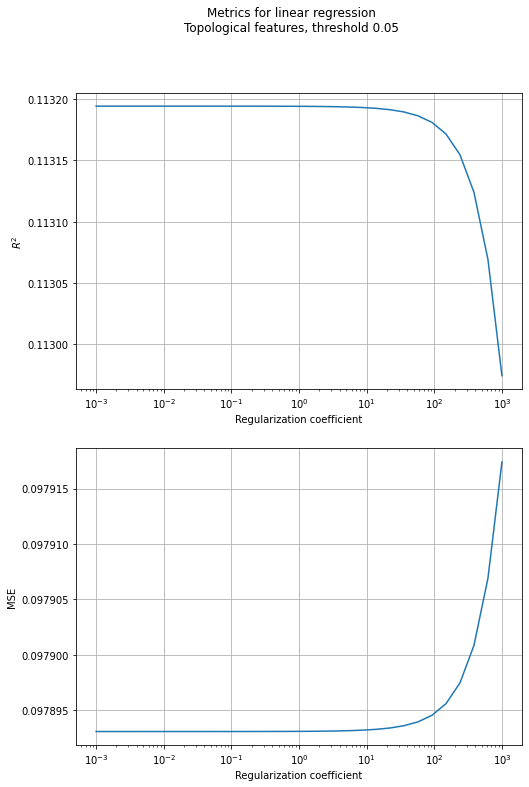

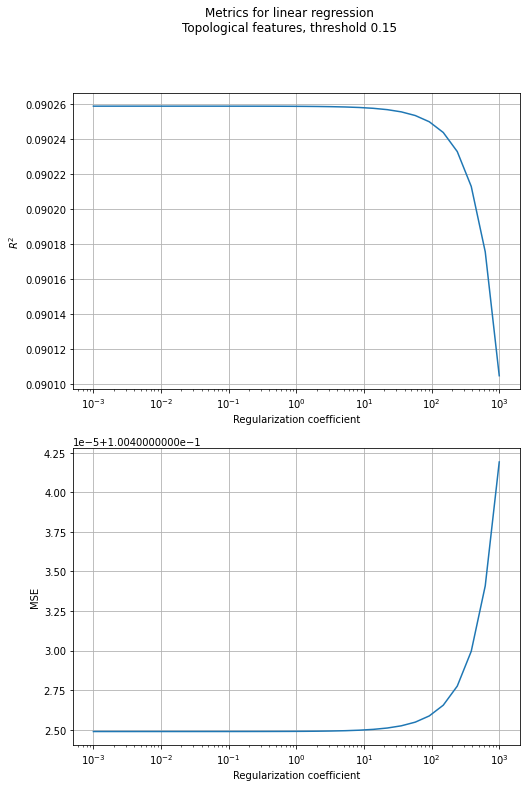

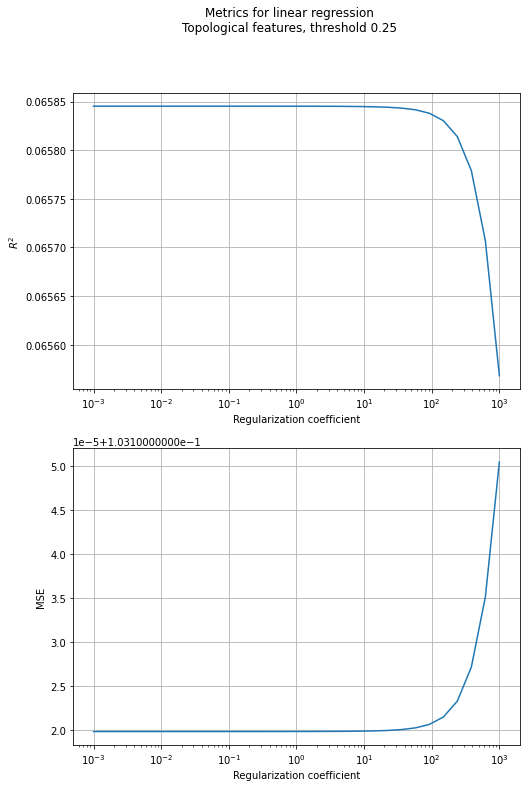

In [51]:
threshs = [0.01, 0.05, 0.15, 0.25]
alphas = np.logspace(-3, 3, num=30)

best_mses = []
best_r2s = []

for thresh in threshs:
    X = prep_data(thresh)
    X = X.loc[y.index]
    X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=RANDOM_SEED, test_size=0.4)

    del X

    scaler = StandardScaler().fit(X_train)
    X_train = scaler.transform(X_train)
    X_test = scaler.transform(X_test)

    r2s, mses = get_metrics(alphas, (X_train, X_test), (y_train, y_test))

    plot_metrics(thresh, alphas, r2s, mses)

    best_mses.append(mses.max())
    best_r2s.append(r2s.max())

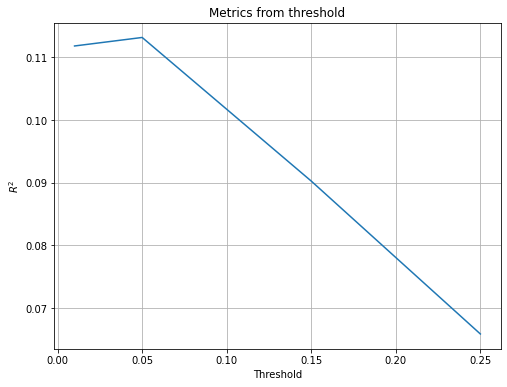

In [52]:
plt.figure(figsize=(8, 6))

sns.lineplot(x=threshs, y=best_r2s)

ax = plt.gca()
ax.set(xlabel="Threshold", ylabel="$ R^2 $", title="Metrics from threshold")

ax.grid()

plt.show()

In [67]:
np.abs(np.corrcoef(X_train.T, y_train)[-1][:-1]).max()

0.12801147205237368

## Coefficients

In [77]:
X = prep_data(0.05)
X = X.loc[y.index]
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=RANDOM_SEED, test_size=0.4)

columns = X.columns

del X

scaler = StandardScaler().fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

In [69]:
model = Ridge().fit(X_train, y_train)

In [82]:
coef_df = pd.DataFrame(data=model.coef_, index=columns)
coef_df = coef_df.reset_index()
coef_df.columns = ["feature", "coef"]

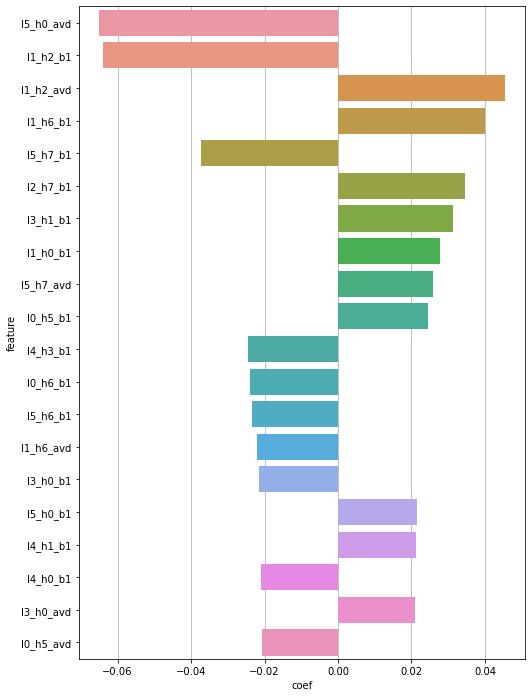

In [94]:
plt.figure(figsize=(8, 12))

sns.barplot(
    data=coef_df.sort_values(by="coef", key=abs, ascending=False).head(20),
    x="coef",
    y="feature",
    zorder=10,
)

plt.grid(axis="x")

plt.show()